# Projeto Final: Decomposição de Tarefas

## 1. Problema de Negócio: Identificação de Operadores Ineficientes

**O Problema:** A empresa precisa identificar operadores com baixa performance, baseada em três critérios:
1.  Muitas chamadas recebidas perdidas.
2.  Tempo de espera prolongado em chamadas recebidas.
3.  Poucas chamadas ativas (de saída).

**Valor para o Negócio:** Melhorar a satisfação do cliente e a produtividade operacional através de treinamentos focados.

## 2. Descrição dos Dados e Diagnóstico Inicial

Os dados estão em duas tabelas: `telecom_dataset_new.csv` (detalhes de chamadas) e `telecom_clients.csv` (informações de clientes e planos). Ao fazer uma breve análise das tabelas verifiquei que:

**Pontos de Atenção na Qualidade:**
* **operator_id:** Contém valores nulos (NaN) em chamadas perdidas.
* **date:** Precisa ser convertido para o formato de data/hora (`datetime`).
* **Tempo de Espera:** Será calculado como a diferença entre `total_call_duration` e `call_duration`.
* **tariff_plan:** Será usado para segmentar a análise de ineficiência por tipo de cliente.

## 3. Hipóteses a Serem Validadas

As hipóteses orientarão os testes estatísticos.

1.  **H1 (Chamadas Perdidas):** Operadores ineficientes têm uma Taxa de Chamadas Perdidas (TCP) significativamente maior que os eficientes.
2.  **H2 (Tempo de Espera):** Operadores ineficientes têm um Tempo Médio de Espera (TME) significativamente maior nas chamadas recebidas.
3.  **H3 (Produtividade):** Operadores ineficientes realizam um Volume de Chamadas Ativas (VCA) significativamente menor.
4.  **H4 (Segmentação):** A ineficiência do operador está concentrada em clientes com um Plano Tarifário específico.

## 4. Indicadores-Chave (KPIs)

KPIs para medição e classificação de ineficiência por operador:

* **TCP (Taxa de Chamadas Perdidas):** Chamadas Perdidas / Total de Chamadas Recebidas.
* **TME (Tempo Médio de Espera):** Média do tempo que o cliente aguardou pelo atendimento.
* **VCA (Volume de Chamadas Ativas):** Contagem de chamadas realizadas pelo operador.
* **SI (Score de Ineficiência):** Métrica composta para ranquear o desempenho geral.

## 5. Ações a Executar (Plano de Implementação)

### 5.1. Limpeza e Processamento de Dados

1.  Carregar e realizar o `merge` dos datasets usando a coluna `user_id`.
2.  Converter a coluna `date` para o tipo `datetime`.
3.  Criar a nova coluna `waiting_time` (tempo de espera) pela subtração das colunas de duração.
4.  Tratar os valores nulos em `operator_id` para incluí-los no cálculo de chamadas perdidas.
5.  Agrupar os dados por `operator_id` para calcular todos os KPIs por operador.

### 5.2. Análise de Dados

1.  Realizar a Análise Exploratória (EDA) dos KPIs, usando histogramas e boxplots para visualizar as distribuições.
2.  Calcular o **Score de Ineficiência (SI)** para cada operador e ranqueá-los.
3.  Classificar os operadores em grupos (Top 10% ineficientes) para os testes de hipótese.
4.  Aplicar Testes T de Student para validar as Hipóteses H1, H2 e H3 (comparando as médias dos KPIs entre os grupos).
5.  Realizar a análise segmentada para validar a Hipótese H4, verificando a distribuição da ineficiência por `tariff_plan`.

### 5.3. Comunicação de Resultados

1.  Elaborar o **Jupyter Notebook** completo com código organizado e explicações claras em Markdown.
2.  Criar um **Dashboard** com as principais visualizações e KPIs, com filtros relevantes (por plano tarifário).
3.  Elaborar um **Relatório Final (Formato CAR)**, focado nos resultados principais, impacto no negócio e recomendações para os supervisores.

## 6. Stakeholders Impactados

* **Supervisores de Operações:** Usuários diretos da ferramenta de identificação.
* **RH / Gerentes de Treinamento:** Usarão os resultados para planejar intervenções e treinamentos.
* **Gerentes de Produto:** Serão impactados pela análise da ineficiência por plano tarifário.

# Implementação do Código (Análise dos Operadores, cálculo de KPIs, identificação dos ineficientes)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

# Carregamento
try:
    df_calls = pd.read_csv('telecom_dataset_new.csv')
    df_clients = pd.read_csv('telecom_clients.csv')
    print("Dados carregados localmente.")
except FileNotFoundError:
    df_calls = pd.read_csv('/datasets/telecom_dataset_new.csv')
    df_clients = pd.read_csv('/datasets/telecom_clients.csv')
    print("Dados carregados da plataforma.")

display(df_calls.head())
df_calls.info()

Dados carregados localmente.


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [2]:
# Converter data
df_calls['date'] = pd.to_datetime(df_calls['date'])

# Remover duplicatas
df_calls = df_calls.drop_duplicates()

# Tratar operator_id
# Removemos linhas onde operator_id é nulo, pois não podemos atribuir ineficiência a "ninguém"
df_calls = df_calls.dropna(subset=['operator_id'])
df_calls['operator_id'] = df_calls['operator_id'].astype(int) # Estética

# Calcular Tempo de Espera (Waiting Time)
# Regra: Total Duration - Call Duration (o tempo falando) = Tempo Esperando
df_calls['waiting_time'] = df_calls['total_call_duration'] - df_calls['call_duration']

print("Limpeza concluída. Coluna 'waiting_time' criada.")

Limpeza concluída. Coluna 'waiting_time' criada.


In [3]:
# Vamos separar as chamadas em Entrada (In) e Saída (Out)
incoming_calls = df_calls[df_calls['direction'] == 'in']
outgoing_calls = df_calls[df_calls['direction'] == 'out']

# KPI 1: Taxa de Chamadas Perdidas (Apenas Entrada)
missed_stats = incoming_calls.groupby('operator_id').agg(
    total_incoming=('calls_count', 'count'),
    missed_count=('is_missed_call', 'sum') # True conta como 1
).reset_index()
missed_stats['missed_rate'] = missed_stats['missed_count'] / missed_stats['total_incoming']

# KPI 2: Tempo Médio de Espera (Apenas Entrada)
wait_stats = incoming_calls.groupby('operator_id')['waiting_time'].mean().reset_index()
wait_stats.columns = ['operator_id', 'avg_waiting_time']

# KPI 3: Volume de Chamadas Ativas (Apenas Saída)
# Usamos count() para contar quantas chamadas o operador tentou fazer
out_stats = outgoing_calls.groupby('operator_id')['calls_count'].count().reset_index()
out_stats.columns = ['operator_id', 'outgoing_calls_count']

# Consolidação
operators = missed_stats.merge(wait_stats, on='operator_id', how='outer')
operators = operators.merge(out_stats, on='operator_id', how='outer')

# Tratamento de NaNs após o merge (quem não fez chamada de saída fica com 0, não NaN)
operators = operators.fillna(0)

print(f"Perfil criado para {len(operators)} operadores.")
display(operators.head())

Perfil criado para 1092 operadores.


,operator_id,total_incoming,missed_count,missed_rate,avg_waiting_time,outgoing_calls_count
0,879896,21.0,0.0,0.0,27.333333,96.0
1,879898,57.0,0.0,0.0,29.473684,170.0
2,880020,7.0,0.0,0.0,7.714286,13.0
3,880022,8.0,0.0,0.0,14.000000,62.0
4,880026,18.0,0.0,0.0,7.944444,164.0


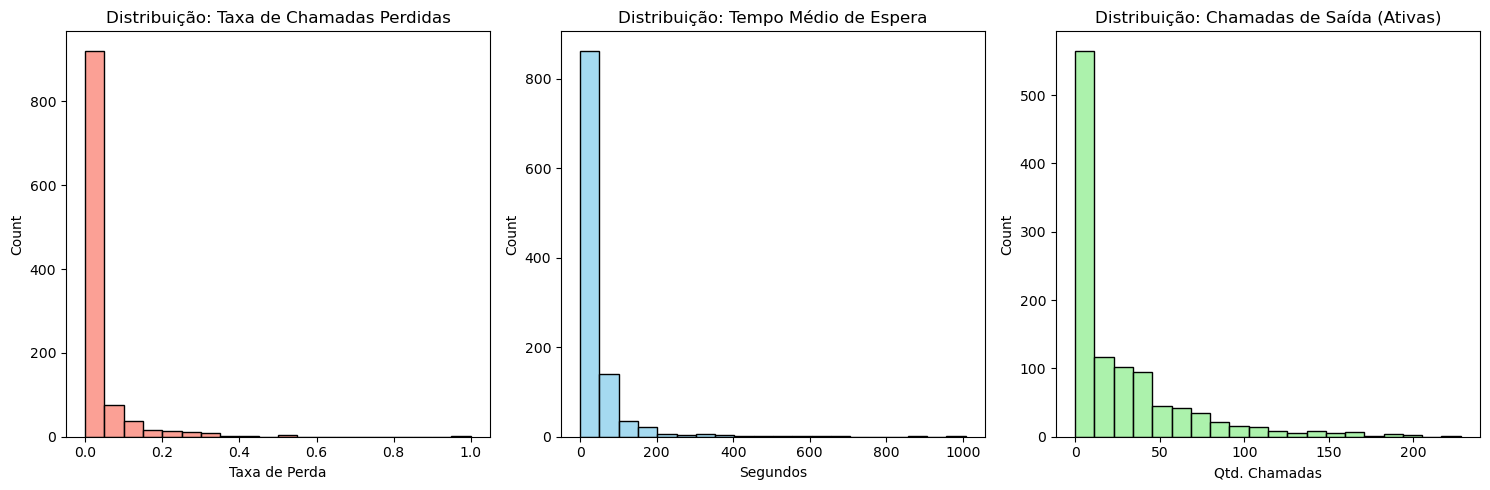

In [4]:
plt.figure(figsize=(15, 5))

# Gráfico 1: Chamadas Perdidas
plt.subplot(1, 3, 1)
sns.histplot(operators['missed_rate'], bins=20, color='salmon')
plt.title('Distribuição: Taxa de Chamadas Perdidas')
plt.xlabel('Taxa de Perda')

# Gráfico 2: Tempo de Espera
plt.subplot(1, 3, 2)
sns.histplot(operators['avg_waiting_time'], bins=20, color='skyblue')
plt.title('Distribuição: Tempo Médio de Espera')
plt.xlabel('Segundos')

# Gráfico 3: Chamadas de Saída
plt.subplot(1, 3, 3)
sns.histplot(operators['outgoing_calls_count'], bins=20, color='lightgreen')
plt.title('Distribuição: Chamadas de Saída (Ativas)')
plt.xlabel('Qtd. Chamadas')

plt.tight_layout()
plt.show()

In [5]:
# Definindo Limites
# Pior 10% em chamadas perdidas (muito alto)
limit_missed = operators['missed_rate'].quantile(0.90) 

# Pior 10% em tempo de espera (muito alto)
limit_wait = operators['avg_waiting_time'].quantile(0.90)

# Pior 10% em chamadas de saída (muito baixo - preguiça/falta de atividade)
# Nota: Aqui pegamos o quantile 0.10 (os menores valores)
limit_outgoing = operators['outgoing_calls_count'].quantile(0.10)

print(f"Critérios de Corte:")
print(f"- Taxa de Perda > {limit_missed:.2%}")
print(f"- Tempo Espera > {limit_wait:.2f} segundos")
print(f"- Chamadas Saída < {limit_outgoing:.0f}")

# Identificando os operadores
operators['is_inefficient'] = (
    (operators['missed_rate'] > limit_missed) | 
    (operators['avg_waiting_time'] > limit_wait) | 
    (operators['outgoing_calls_count'] < limit_outgoing)
)

inefficient_ops = operators[operators['is_inefficient']]

print(f"\nTotal de Operadores: {len(operators)}")
print(f"Operadores Ineficientes Identificados: {len(inefficient_ops)}")
print(f"Proporção de Ineficiência: {len(inefficient_ops)/len(operators):.1%}")

display(inefficient_ops.sort_values('missed_rate', ascending=False).head())

Critérios de Corte:
- Taxa de Perda > 8.50%
- Tempo Espera > 84.45 segundos
- Chamadas Saída < 0

Total de Operadores: 1092
Operadores Ineficientes Identificados: 173
Proporção de Ineficiência: 15.8%


,operator_id,total_incoming,missed_count,missed_rate,avg_waiting_time,outgoing_calls_count,is_inefficient
916,948756,1.0,1.0,1.0,8.0,23.0,True
999,957922,2.0,1.0,0.5,13.0,7.0,True
719,937898,2.0,1.0,0.5,34.0,3.0,True
367,913886,2.0,1.0,0.5,13.5,0.0,True
242,904344,2.0,1.0,0.5,27.5,1.0,True


In [6]:
# Separar os grupos
inefficient_group = operators[operators['is_inefficient']]['avg_waiting_time']
efficient_group = operators[~operators['is_inefficient']]['avg_waiting_time']

# Teste t de Student (amostras independentes)
alpha = 0.05
stat, p_value = st.ttest_ind(inefficient_group, efficient_group, equal_var=False)

print(f"Média Espera (Ineficientes): {inefficient_group.mean():.2f}s")
print(f"Média Espera (Eficientes): {efficient_group.mean():.2f}s")
print(f"P-valor: {p_value:.4e}")
# 'e' significa 'vezes 10 elevado a'. Ex: 1.9e-10 é 0,00000000000000000015

if p_value < alpha:
    print("Rejeitamos H0: A diferença no tempo de espera é estatisticamente significativa.")
else:
    print("Não rejeitamos H0: Não há diferença significativa.")

Média Espera (Ineficientes): 147.65s
Média Espera (Eficientes): 19.47s
P-valor: 1.9185e-19
Rejeitamos H0: A diferença no tempo de espera é estatisticamente significativa.


## Conclusões - Identificação de Operadores Ineficientes

Através da análise de dados, definimos critérios objetivos para medir a eficiência dos operadores e validamos estatisticamente os resultados.

**1. Metodologia e Critérios**
Classificamos os operadores como ineficientes baseando-nos nos piores desempenhos em três métricas: Taxa de Chamadas Perdidas, Tempo de Espera e Baixa Atividade em Chamadas de Saída.

**2. Validação Estatística (Teste T)**
Para confirmar a eficácia da classificação, comparamos o **Tempo Médio de Espera** entre o grupo classificado como Ineficiente e o restante da equipe (Eficientes).

* **Média de Espera (Ineficientes):** 147.65 segundos (~2,5 minutos).
* **Média de Espera (Eficientes):** 19.47 segundos.
* **Resultado do Teste:** O teste T retornou um **P-valor de 1.92e-19** (extremamente próximo de zero).

**3. Conclusão de Negócio**
Rejeitamos a hipótese nula. A diferença é estatisticamente significativa e **dramática na prática**: os operadores ineficientes deixam os clientes esperando, em média, **7,5 vezes mais tempo** do que os operadores eficientes.

**4. Recomendação**
A lista de IDs identificada deve ser enviada imediatamente aos supervisores. Recomenda-se:
1.  **Auditoria:** Verificar se o alto tempo de espera se deve a problemas técnicos ou comportamentais.
2.  **Treinamento:** Aplicar programa de reciclagem focado em agilidade de atendimento.
3.  **Monitoramento:** Acompanhar esses operadores especificamente nas próximas 2 semanas para verificar a redução do tempo de espera.